$$
\kappa(u) = \left(\frac{3u(1-u)}{3u^3 + (1-u)^3}\right)^2  + \mu
$$
$$
\begin{equation}
\left\{
	\begin{aligned}
	&-\nabla\cdot(\kappa(u)\nabla u) = f, &x \in \Omega, \\
	&u = 0, &x \in \partial\Omega
\end{aligned}
\right.
\end{equation}
$$

$$
	f(x; i^\star) = 100 \exp(-50 ||x - x_{c, i^\star}||_2^2)\mathbf{1}_{\Omega_{i^\star}}(x)
$$

123.93509
67.30321
42.26125
30.864126
23.62039
19.900028
16.814934
15.174686
13.429742
12.512767
11.323279
10.720312
9.818434
9.381351
8.656549
8.321721
7.719728
7.4551907
6.94508
6.7324657
6.294388
6.1219163
5.741982
5.6014333
5.269303
5.1545897
4.862239
4.7686696
4.5096993
4.4335494
4.2027636
4.141026
3.9341602
3.8843787
3.6979022
3.6580613
3.4890342
3.4574726
3.3034396
3.2787862
3.1376927
3.118815
2.9889326
2.9748971
2.8547733
2.8448076
2.7332163
2.726678
2.6225863
2.6189454
2.5214748
2.520292
2.4286964
2.429603
2.3432455
2.345935
2.2642717
2.268485
2.1910486
2.1965697
2.1229513
2.1295998
2.059449
2.0670674
2.0000782
2.008533
1.9444376
1.953617
1.8921767
1.9019849
1.8429896
1.8533423
1.7966068
1.8074327
1.7527902
1.7640256
1.7113266
1.7229187
1.6720299
1.6839302
1.6347305
1.6468971
1.5992782
1.6116744
1.565536
1.5781305
1.5333823
1.5461452
1.5027041
1.5156116
1.4734021
1.4864304
1.4453838
1.4585131
1.418566
1.4317778
1.3928702
1.4061507
1.368228
1.3815628
1.3445737
1.3579506
1.32184

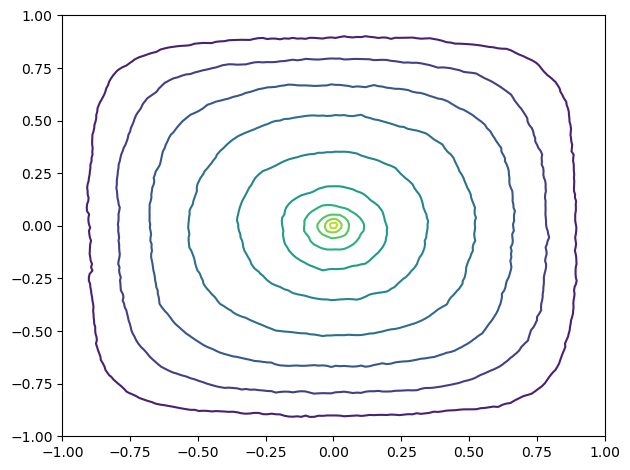

In [38]:
from utils import reaction_A, reaction_b_dir
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import spsolve
from utils import normal

def steepest_descent(A, b, x0, maxiter):
	x = x0
	for i in range(maxiter):
		r = b - A@x
		alpha = np.dot(r, r) / np.dot(r, A@r)
		x = x + alpha * r
		print(np.linalg.norm(A@x - b))
	return x
    

N = 128
h = 2 / (N-1)
k = 2
xx, yy = np.meshgrid(
	np.linspace(-1, 1, N),
	np.linspace(-1, 1, N),
)
f = normal(xx, yy, h, (0, 0))
kappa = np.random.uniform(0.1, 2, (N, N))
A = reaction_A(N, kappa).astype(np.float32)
b = reaction_b_dir(f, 0, h)

u = steepest_descent(A, b.astype(np.float32), np.random.rand(N**2).astype(np.float32), 2000).reshape(N, N)
# u = spsolve(A.tocsr(), b).reshape(N, N)
plt.contour(xx, yy, u, levels=10)
# plt.colorbar()
plt.tight_layout()
plt.show()
    

In [16]:
import torch
from torch.autograd import grad
A = torch.rand(3, 3)
x = torch.rand(3, 1)
x.requires_grad = True
b = torch.rand(3, 1)
r = A @ x - b
l = r.T @ r
dfdx = grad(l, x)[0]
print(dfdx)
print(2 * A.T@r)

tensor([[-0.9561],
        [-1.0294],
        [-0.3387]])
tensor([[-0.9561],
        [-1.0294],
        [-0.3387]], grad_fn=<MmBackward0>)


In [1]:
import pandas as pd
from utils import fd_solve_nlinear, force
import numpy as np
from tqdm import tqdm

GridSize = 128
area = ((0, 0), (1, 1))
xx, yy = np.meshgrid(
    np.linspace(area[0][0], area[1][0], GridSize),
    np.linspace(area[0][1], area[1][1], GridSize)
)
# mu = 0.1

# fd_solve_nlinear(GridSize, area, 0.1, (0.1, 0.1))
ans = []
N = 300
centers = np.random.uniform(0.1, 1, (N, 2))
forces = []
for c in centers:
    forces.append(force(xx, yy, c))
np.save(f'./fit_nlinear/DLdata/{GridSize}/forceForTest.npy', np.stack(forces))

mus = np.random.uniform(0.1, 1, N)
mus_for_save = np.ones((1, GridSize, GridSize)) * mus.reshape((N, 1, 1))
np.save(f'./fit_nlinear/DLdata/{GridSize}/muForTest.npy', mus)
# df = pd.DataFrame()
for center, mu in tqdm(zip(centers, mus)):
	ans.append(fd_solve_nlinear(GridSize, area, mu, center,))

np.stack(ans)
np.save(f'./fit_nlinear/DLdata/{GridSize}/UForTest.npy', ans)

300it [10:26,  2.09s/it]


In [ ]:
from FVM.src.UniformICD import UniformFVM
from FVM.src.Problem.test_uniform import *
from FVM.src.utils import show_errors

# Test zxp case !!!
case_ns = list(range(10))
print(f"|{'Method': ^8s}|{'Case ID': ^8s}|{'Mesh Type': ^18s}|{'hmesh': ^11s}|{'error_max': ^11s}|{'ratio': ^7s}|{'error_l2': ^11s}|{'ratio': ^7s}|{'error_h1': ^11s}|{'ratio': ^7s}|")
print(f'|{":--:": ^8s}|{":--:": ^8s}|{":--:": ^18s}|{":--:": ^11s}|{":--:": ^11s}|{":--:": ^7s}|{":--:": ^11s}|{":--:": ^7s}|{":--:": ^11s}|{":--:": ^7s}|')
for case_n in case_ns:
	mesh_type = 'quadrangle_uniform'
		# triangle_classic triangle_random triangle_uniform triangle_kershaw
		# quadrangle_uniform quadrangle_random  quadrangle_kershaw
	n_levels = 5
	hmeshes = []
	errors_max = []
	errors_l2 = []
	errors_h1 = []

	for i in range(n_levels):
		N = 2**(i+3)
		problem = zxpProblem(N, N, ((0, 0), (1, 1)), case_n, 1e-9)
		solver = UniformFVM(((0, 0), (1, 1)), N, N, problem)
		solver.solve(solver_name=None)
		hmesh, error_max, error_l2, error_h1 = solver.compute_errors()

		hmeshes.append(hmesh)
		errors_max.append(error_max)
		errors_l2.append(error_l2)
		errors_h1.append(error_h1)

	for s in show_errors(hmeshes, errors_max, errors_l2, errors_h1):
		print(f'|{"ICD": ^8s}|{case_n: ^8}|{mesh_type: ^18s}|' + s)

In [ ]:
from Problems.NonlinearProblem import *
from plots import my_plot
from UniformICD import UniformFVM

def fvm_solve_nlinear(GridSize, area, mu, center=(0.5, 0.5), 
					Picard_maxiter=1000, eps=1e-7):
	u0 = np.random.rand(GridSize, GridSize)
	problem = NonLinearProblem(None, center, N, area)
	solver = UniformFVM(area, N, N, problem)
	solver.solve(solver_name = None)
	u0,  b = solver.ua, solver.b

	for i in range(Picard_maxiter):
		problem = NonLinearProblem(kappa(u0.reshape(GridSize, GridSize), mu), center, N, area)

		solver = UniformFVM(area, N, N, problem)
		solver.solve(solver_name = None)
		newA = solver.A.tocsr()
		newu = solver.ua

		# delta = ((newu - u0)**2 * h**2).sum()
		delta = np.linalg.norm(newu - u0)
		# error = ((newA @ u0 - b)**2 * h**2).sum()
		error = np.linalg.norm(newA @ u0 - b)
		print(f"Itr: {i}\t Delta: {delta:.3e}\t Error: {error:.3e}\t")

		if delta <= eps or error <= eps:
			u = newu.reshape(GridSize, GridSize)
			break
		else:
			u0, A0 = newu, newA
	return u


N = 128
mu = 0.1
center = (0.1, 0.1)
area = ((0, 0), (1, 1))

solution = fvm_solve_nlinear(N, area, mu)

In [ ]:
from FVM.src.ICD import VolumnCenteredScheme
from FVM.src.Problem.heatProblem import ChipHeatDissipation
from FVM.src.utils import readmesh

mesh = readmesh('FVM/my_meshes/UniformQuad-HeatChip-64.obj')
problem = ChipHeatDissipation(None, 0) 
solver = VolumnCenteredScheme(mesh, problem)

faces = list(mesh.faces())
fh = faces[88]
AK = solver._element_stiffness_matrix(fh)
AK

In [ ]:
import torch

a = torch.Tensor([1, 2, 3, torch.inf])
print(type(torch.inf))